### Data Visualization

This section consists of two parts:

This Python script serves as a real-time monitoring tool for traffic violations using MongoDB and Matplotlib. It continuously polls the violations collection in the fit3182_db database, aggregating newly processed records based on the processed_time field. Every 0.1 seconds, it queries for updates, calculates the number of violations and the average speed within the latest polling window, and dynamically appends the results to two synchronized line plots: one tracking violation counts and the other showing average speed over time. The plots are displayed using Matplotlib's interactive mode, allowing live updates without restarting the figure.

Beyond simple plotting, the script enhances interpretability by computing descriptive statistics—minimum, first quartile (Q1), median, third quartile (Q3), and maximum—and overlaying them as horizontal lines in different colors. Each statistical line is annotated to provide immediate visual feedback on the data distribution. Furthermore, extreme values (minimum and maximum) are highlighted using arrow annotations, offering quick insight into anomalies or peaks in the traffic pattern.

In terms of future analytics, this framework can be extended to include outlier detection mechanisms by flagging values that fall significantly outside the interquartile range. Additionally, incorporating trend lines or rolling averages could help reduce noise and reveal underlying traffic behavior patterns. Time-based aggregations such as hourly or daily heatmaps would offer deeper insights into peak violation periods. Segmenting the plots by camera ID could identify location-specific issues. Real-time alerts could also be introduced to trigger notifications when sudden spikes in violations or unusual speed readings are detected. Finally, integrating with dashboarding tools like Dash or Streamlit could provide more interactive capabilities such as zooming, filtering, and on-demand data export, transforming this script into a comprehensive traffic analytics solution.

<IPython.core.display.Javascript object>


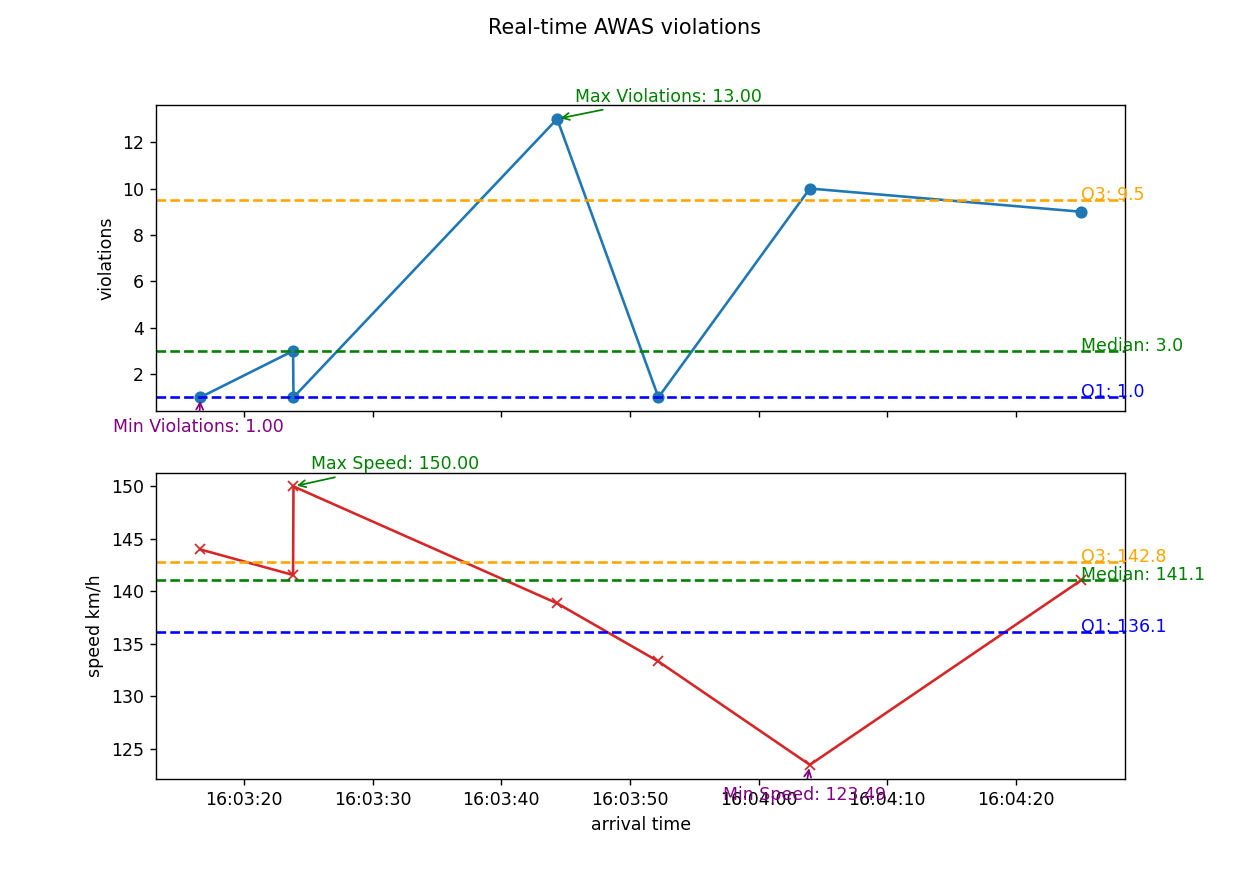

/tmp/ipykernel_92/1728754319.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  line_cnt, = ax_cnt.plot_date([], [], marker='o', linestyle='-')
/tmp/ipykernel_92/1728754319.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  line_spd, = ax_spd.plot_date([], [], marker='x', linestyle='-', color='tab:red')


Polling MongoDB every 0.1s… Ctrl-C to stop
Stopped by user


In [2]:
import datetime as dt
import time
from pymongo import MongoClient, errors as pymongo_errors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from copy import deepcopy

# ——————————————
# MongoDB connection
# ——————————————
host_ip = "10.192.64.67"
client = MongoClient(host_ip, 27017)
coll   = client["fit3182_db"]["violations"]

# ——————————————
# Interactive plotting setup
# ——————————————
%matplotlib notebook
plt.ion()

times, counts, speeds = [], [], []

fig, (ax_cnt, ax_spd) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
fig.suptitle("Real-time AWAS violations")

ax_spd.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

line_cnt, = ax_cnt.plot_date([], [], marker='o', linestyle='-')
line_spd, = ax_spd.plot_date([], [], marker='x', linestyle='-', color='tab:red')

ax_cnt.set_ylabel("violations")
ax_spd.set_ylabel("speed km/h")
ax_spd.set_xlabel("arrival time")

def annotate_extremes(ax, x, y, label):
    """
    Annotate the maximum and minimum values on a matplotlib Axes object.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib Axes on which to annotate.
        x (list): List of x-axis values corresponding to the y values.
        y (list): List of y-axis values to find min and max for annotation.
        label (str): Label to include in the annotation text (e.g., "Speed").

    Notes:
        - This function adds arrows and labels at the maximum and minimum y-values.
        - If 'y' is empty, the function exits.
    """
    if len(y) == 0:
        return
    ymax = max(y)
    ymin = min(y)
    xmax = x[y.index(ymax)]
    xmin = x[y.index(ymin)]
    ax.annotate(f"Max {label}: {ymax:.2f}", xy=(xmax, ymax), xycoords='data',
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color='green'), color='green')
    ax.annotate(f"Min {label}: {ymin:.2f}", xy=(xmin, ymin), xycoords='data',
                xytext=(-50, -20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color='purple'), color='purple')
    
def compute_statistics(data):
    """
    Compute basic statistics for a list or array of numeric values.

    Parameters:
        data (list or np.ndarray): A sequence of numeric values.

    Returns:
        dict: A dictionary containing the minimum, first quartile (Q1),
              median, third quartile (Q3), and maximum of the data.

    Example:
        compute_statistics([1, 2, 3, 4, 5])
        {'min': 1, 'q1': 2.0, 'median': 3.0, 'q3': 4.0, 'max': 5}
    """
    return {
        'min': np.min(data),
        'q1': np.percentile(data, 25),
        'median': np.median(data),
        'q3': np.percentile(data, 75),
        'max': np.max(data),
    }

# ——————————————
# Polling parameters & pipeline
# ——————————————
POLL_SEC = 0.1
last_ts  = dt.datetime.utcnow()

pipeline_template = [
    {"$match": {"records.processed_time": {"$gt": None}}},
    {"$unwind": "$records"},
    {"$match": {"records.processed_time": {"$gt": None}}},
    {"$group": {
        "_id":   "$records.processed_time",
        "count": {"$sum": 1},
        "avg_spd": {"$avg": "$records.speed_reading"}
    }},
    {"$sort": {"_id": 1}}
]

print(f"Polling MongoDB every {POLL_SEC}s… Ctrl-C to stop")

try:
    while True:
        pipe = deepcopy(pipeline_template)
        pipe[0]["$match"]["records.processed_time"]["$gt"] = last_ts
        pipe[2]["$match"]["records.processed_time"]["$gt"] = last_ts

        got_new = False
        for doc in coll.aggregate(pipe, allowDiskUse=False):
            t       = doc["_id"]
            count   = doc["count"]
            avg_spd = doc["avg_spd"]
            if t > last_ts:
                last_ts = t
            else:
                last_ts  = dt.datetime.utcnow()
            times.append(t)
            counts.append(count)
            speeds.append(avg_spd)
            got_new = True

            if len(times) > 30:
                times.pop(0)
                counts.pop(0)
                speeds.pop(0)

        if got_new:
            line_cnt.set_data(times, counts)
            line_spd.set_data(times, speeds)
            
            ax_cnt.relim(); ax_cnt.autoscale_view()
            ax_spd.relim(); ax_spd.autoscale_view()
            
            ax_cnt.texts.clear()
            ax_spd.texts.clear()
            
            if len(speeds) >= 5:
                for line in ax_spd.lines[1:]:
                    line.remove()

                stats = compute_statistics(speeds)
                ax_spd.axhline(stats['q3'], color='orange', linestyle='--', label='3rd Quartile (Q3)')
                ax_spd.axhline(stats['median'], color='green', linestyle='--', label='Median')
                ax_spd.axhline(stats['q1'], color='blue', linestyle='--', label='1st Quartile (Q1)')

                x_pos = times[-1]
                ax_spd.annotate(f"Q3: {stats['q3']:.1f}", xy=(x_pos, stats['q3']), color='orange')
                ax_spd.annotate(f"Median: {stats['median']:.1f}", xy=(x_pos, stats['median']), color='green')
                ax_spd.annotate(f"Q1: {stats['q1']:.1f}", xy=(x_pos, stats['q1']), color='blue')
                
            if len(counts) >= 5:
                for line in ax_cnt.lines[1:]:
                    line.remove()

                stats = compute_statistics(counts)

                ax_cnt.axhline(stats['q3'], color='orange', linestyle='--', label='3rd Quartile (Q3)')
                ax_cnt.axhline(stats['median'], color='green', linestyle='--', label='Median')
                ax_cnt.axhline(stats['q1'], color='blue', linestyle='--', label='1st Quartile (Q1)')

                x_pos = times[-1]
                ax_cnt.annotate(f"Q3: {stats['q3']:.1f}", xy=(x_pos, stats['q3']), color='orange')
                ax_cnt.annotate(f"Median: {stats['median']:.1f}", xy=(x_pos, stats['median']), color='green')
                ax_cnt.annotate(f"Q1: {stats['q1']:.1f}", xy=(x_pos, stats['q1']), color='blue')
            
            annotate_extremes(ax_cnt, times, counts, "Violations")
            annotate_extremes(ax_spd, times, speeds, "Speed")
            fig.canvas.draw()
            fig.canvas.flush_events()

        plt.pause(POLL_SEC)

except KeyboardInterrupt:
    print("Stopped by user")
finally:
    client.close()


This script connects to a MongoDB database hosted at 10.192.64.67 and visualizes traffic violation data on an interactive map using the Folium library. It begins by accessing the fit3182_db database and retrieving data from two collections: violations and cameras. A base map is initialized and centered on the coordinates of camera ID 2 (because its at the center). All camera coordinates are extracted and stored in a list for subsequent mapping operations.

The first part of the script focuses on visualizing instantaneous speed violations (where the start and end camera IDs are the same) within a specified time window—between 8:00 AM and 9:00 AM on January 1, 2024 (which can be changed to other timeslot accordingly by changing the input date parameter)—and across selected cameras (IDs 1, 2, and 3). Using an aggregation pipeline, it computes the number of violations per camera. Each camera is then represented on the map using a Folium marker. These markers are color-coded based on the severity of the violations: green for low counts, orange for moderate counts, and red for high counts, using a threshold value of 175 (self-defined). Each marker includes a popup that displays the camera's latitude, longitude, and the number of violations recorded during the time window.

In the second part, the script shifts to visualizing average speed violations between specific camera pairs (1→2 and 2→3) during the same time frame. It aggregates both the average speed and the total number of violations for each camera pair. Then, it draws lines connecting the respective camera locations on the map to represent the route taken. These lines include popups displaying the calculated average speed and the number of violations between the two checkpoints.

Overall, the part below provides a geographic view of traffic violations, enabling users to quickly assess high-violation areas through color-coded markers and inter-camera trends via connecting lines. This is particularly useful for monitoring traffic patterns, detecting speeding behavior, and identifying violation hotspots.

In [115]:
from pymongo import MongoClient
import folium
from datetime import datetime, timezone

host_ip = "10.192.64.67"

client = MongoClient(host_ip, 27017)
db = client.fit3182_db
violation = db.violations

camera = db.cameras

starting_cam = camera.find_one({'camera_id': 2})

start_lat, start_lon = starting_cam['latitude'], starting_cam['longitude']

fomap = folium.Map(location=[start_lat, start_lon], zoom_start=15)

coords = []

for cam in camera.find().sort("camera_id", 1):
    coords.append((cam["latitude"], cam["longitude"]))

start = datetime(2024, 1, 1, 8, 0, 0, tzinfo=timezone.utc)
end   = datetime(2024, 1, 1, 9, 0, 0, tzinfo=timezone.utc)

# 3. Desired cameras
cams = [1, 2, 3]

pipeline = [
    {"$unwind": "$records"},

    {"$match": {
        "records.timestamp_start": {"$gte": start, "$lte": end},
        "records.camera_id_start": {"$in": cams},
        "records.camera_id_end":   {"$in": cams}
    }},

    {"$group": {
        "_id": "$records.camera_id_start",
        "violation_count": {"$sum": 1}
    }},

    {"$sort": {"_id": 1}}
]

threshold = 175

idx = 0
for doc in violation.aggregate(pipeline):
    cam_lat, cam_lon = coords[idx][0], coords[idx][1]
    violation_count = doc['violation_count']
    
    if violation_count >= threshold:
        color = 'red'
    elif violation_count >= threshold * 0.5:
        color = 'orange'
    else:
        color = 'green'

    folium.Marker(location=[cam_lat, cam_lon ], popup=f"lat={cam_lat:.2f}, lon={cam_lon:.2f}, Violation={doc['violation_count']}",icon=folium.Icon(color=color, icon='camera')).add_to(fomap)
    idx += 1
    
pipeline_avg = [
    {"$unwind": "$records"},

    {"$match": {
        "records.timestamp_start": {"$gte": start, "$lte": end},
        "$or": [
            {"records.camera_id_start": 1, "records.camera_id_end": 2},
            {"records.camera_id_start": 2, "records.camera_id_end": 3}
        ],
        "records.speed_reading": {"$ne": None} 
    }},

    {"$group": {
        "_id": {
            "from_cam": "$records.camera_id_start",
            "to_cam": "$records.camera_id_end"
        },
        "average_speed": {"$avg": "$records.speed_reading"},
        "violation_count": {"$sum": 1}
    }},

    {"$sort": {"_id.from_cam": 1, "_id.to_cam": 1}}
]

idx = 0
for doc in violation.aggregate(pipeline_avg):
    folium.PolyLine(
        locations=[coords[idx],coords[idx+1]],
        color="blue",
        weight=3,
        opacity=0.7,
        popup=f"Avg Speed={doc['average_speed']:.2f} km/h, Violations={doc['violation_count']}"
    ).add_to(fomap)
    idx +=1
    


In [116]:
fomap